In [1]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
import scipy 
import scipy.stats as st
from scipy.stats import kurtosis

#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

import networkx as nx
import community.community_louvain as community_louvain # pip install community

dir = '~/DataAnalysis/data/Sprints/HighRes/'

In [2]:
def get_timed_rows(dataframe,duration_of_encounters):
    x = dataframe.sample(1)
    A = x.mean_time.values.round(0) - duration_of_encounters
    B = x.mean_time.values.round(0)
    timed_rows = dataframe.loc[(dataframe.mean_time > A[0]) & (dataframe.mean_time < B[0])]
    return timed_rows
    
def get_timed_encounter_stats(dataframe, distance_class, duration_of_encounters):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
            
    Nrows = get_timed_rows(df_q,duration_of_encounters)
    avg_dist = np.mean(Nrows.avg_dist_from_source)
    mean_time_whiff=np.mean(Nrows.mean_time)
#     mean_conc=np.mean(Nrows_cont.odor)
    pack_data=np.vstack([Nrows.mean_concentration,Nrows.mean_ef,Nrows.log_whiff,Nrows.whiff_ma,Nrows.std_whiff])
    return pack_data,avg_dist,len(Nrows),mean_time_whiff


def gather_stat_timed(dataframe, distance_class, duration_of_encounters,X,y,D,N,T):
    for i in range(500):
        xx,dx,n,t=get_timed_encounter_stats(dataframe,
                                               distance_class, duration_of_encounters)
        X.append(xx)
        D.append(dx)
        y.append(distance_class)
        N.append(n)
        T.append(t)
        
    return X,y,D,N,T

In [3]:
def create_class_column_fullts(dataframe):
    dataframe.loc[dataframe.distance_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.distance_from_source >= 5)  & (dataframe.distance_from_source < 30), 'type'] = 1
    dataframe.loc[dataframe.distance_from_source >= 30, 'type'] = 2
    return dataframe

def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 30), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 30, 'type'] = 2
    return dataframe

In [4]:
def get_statistics(df,index,fdf):
    osm.avg_distance(df,index,fdf)
    osm.mean_conc(df,index,fdf)
    osm.motion_statistics(df,index,fdf)
    osm.whiff_blank_duration(df,index,fdf)
    osm.trajectory_speed(df,index,fdf)
    osm.encounter_frequency(df,index,fdf,1,2)
    osm.mean_avg(df,index,fdf)
    osm.mean_t(df,index,fdf)
    osm.std_whiff(df,index,fdf)

In [5]:
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

In [12]:
lookback_time = 10
# filters=[2,4,6,8,10,15,20,40,60,70,80,90]

lpf=[]
filters=[1]
for i in range(len(filters)):
    print(filters[i])
    ## load dataframes
    df_windy=pd.read_hdf(dir+'Windy/WindyMASigned.h5')
    df_notwindy=pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5')
    df_forest=pd.read_hdf(dir+'Forest/ForestMASigned.h5')
    
    ## combine dataframes
    desert = pd.concat([df_notwindy,df_windy,df_forest])
    desert.reset_index(inplace=True, drop=True)
    trainset= desert
    
    ## low pass filtering
    fs=200
    nyq=fs*0.5
    cutoff_freq=filters[i]
    sos = signal.butter(2, cutoff_freq, 'low',fs=200, output='sos')
    filtered = signal.sosfilt(sos, trainset.odor)
    dt = trainset.master_time[1]-trainset.master_time[0]
    time = []
    time.append(0)
    for i in range(1,len(trainset)):
        time.append(time[i-1]+dt)
    trainset['time'] = time
    trainset['odor']=filtered
    
    trainset.to_hdf('../../Figure/lowpassfilter/1.h5', key='trainset', mode='w')

1


In [8]:
lookback_time = 10
filters=[2,4,6,8,10,15,20,40,60,70,80,90]

lpf=[]
# filters=[10,20,30]
for i in range(len(filters)):
    print(filters[i])
    ## load dataframes
    df_windy=pd.read_hdf(dir+'Windy/WindyMASigned.h5')
    df_notwindy=pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5')
    df_forest=pd.read_hdf(dir+'Forest/ForestMASigned.h5')
    
    ## combine dataframes
    desert = pd.concat([df_notwindy,df_windy,df_forest])
    desert.reset_index(inplace=True, drop=True)
    trainset= df_forest
    
    ## low pass filtering
    fs=200
    nyq=fs*0.5
    cutoff_freq=filters[i]
    sos = signal.butter(2, cutoff_freq, 'low',fs=200, output='sos')
    filtered = signal.sosfilt(sos, trainset.odor)
    dt = trainset.master_time[1]-trainset.master_time[0]
    time = []
    time.append(0)
    for i in range(1,len(trainset)):
        time.append(time[i-1]+dt)
    trainset['time'] = time
    trainset['odor']=filtered
    
#     trainset.to_hdf('../../Figure/lowpassfilter/80Hz.h5', key='trainset', mode='w')
    
    ## calulcate statistics
    np.seterr(divide = 'ignore') 
    index = osm.get_index_forest(trainset)
    fdf = pd.DataFrame()
    get_statistics(trainset,index,fdf)
    stat_cal_set=create_class_column(fdf)
    
    ## calculate statistics
    D_train=[]
    D_test=[]
    mean_time_train=[]
    mean_time_test=[]
    Xtest = []
    ytest = []
    Xtrain = []
    ytrain = []
    Nrows_train = []
    Nrows_test = []

    for distance_class in [0,1]:
        Xtrain, ytrain, D_train,Nrows_train,mean_time_train = gather_stat_timed(stat_cal_set,distance_class,
                          lookback_time, Xtrain,ytrain,D_train,Nrows_train,
                          mean_time_train)

    column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
                 'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
                 'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
                 'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
                 'st_min','st_max','st_mean','st_std_dev','st_k']

    traindf=pd.DataFrame(columns = column_names)
    c1=[]
    for i in range(len(Xtrain)):
        if(np.size(Xtrain[i])==0):
            c1.append(i)
            continue
        else:
            X=[]
            for j in range(len(Xtrain[i])):
                X.append(calc_val(Xtrain[i][j]))
            traindf.loc[i]=np.ravel(X)

    traindf['distance']=np.delete(D_train, c1)
    
    y=traindf.distance
    x=traindf.loc[traindf.distance.notnull(), column_names].values
    x =sm.add_constant(x)
    x[np.isnan(x)] =0
    olsmod = sm.OLS(y, x)
    olsres = olsmod.fit()
    ypred = olsres.predict(x)
    lpf.append(olsres.rsquared)    
    
print('done')
lpdf=pd.DataFrame()
lpdf['frequency']=filters
lpdf['rsquared']=lpf
lpdf.to_hdf('../../Figure/lowpassfilter/LpfForest.h5', key='lpdf', mode='w')

2
4
6
8
10
15
20
40
60
70
80
90
done


In [58]:
lpdf=pd.DataFrame()
lpdf['frequency']=filters
lpdf['rsquared']=lpf
lpdf.to_hdf('../../Figure/lowpassfilter/LpfLWS.h5', key='lpdf', mode='w')

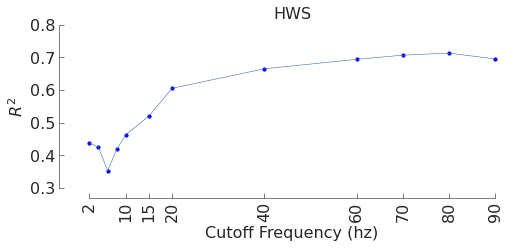

In [64]:
lpdf=pd.read_hdf('../../Figure/lowpassfilter/LpfHWS.h5')
f,ax=plt.subplots(1,1,figsize=(8,3))
ax.plot(lpdf.frequency,lpdf.rsquared,c='b',rasterized=True, linewidth=0.6)
ax.scatter(lpdf.frequency,lpdf.rsquared,c='blue',s=10,rasterized=True)
ax.grid(False)
ax.set_rasterization_zorder(-20)

ax.set_xlabel('Cutoff Frequency (hz)')
# ax.xaxis.set_label_coords(0.5, -0.2)
ax.set_ylabel('$R^2$',rotation=90)
# ax.yaxis.set_label_coords(-0.06, 0.45)

x_ticks=np.array(lpdf.frequency)
mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[2,10,15,20,40,60,70,80,90],
                            linewidth=0.5)
ax.set_title('HWS')
ax.set_xticklabels([2,10,15,20,40,60,70,80,90],rotation=90)
figurefirst.mpl_functions.set_fontsize(ax, 16)

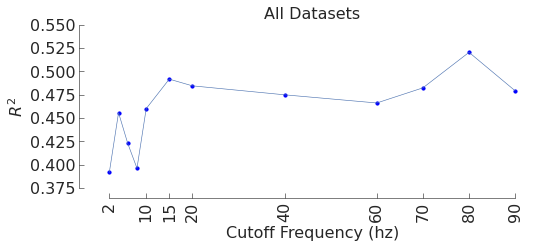

In [63]:
lpdf=pd.read_hdf('../../Figure/lowpassfilter/LpfAll.h5')
f,ax=plt.subplots(1,1,figsize=(8,3))
ax.plot(lpdf.frequency,lpdf.rsquared,c='b',rasterized=True, linewidth=0.6)
ax.scatter(lpdf.frequency,lpdf.rsquared,c='blue',s=10,rasterized=True)
# ax.set_xlim(1.6,)

ax.grid(False)
ax.set_rasterization_zorder(-20)

ax.set_xlabel('Cutoff Frequency (hz)')
# ax.xaxis.set_label_coords(0.5, -0.2)
ax.set_ylabel('$R^2$',rotation=90)
# ax.yaxis.set_label_coords(-0.06, 0.45)

x_ticks=np.array(lpdf.frequency)
mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[2,10,15,20,40,60,70,80,90],
                            linewidth=0.5)
ax.set_title('All Datasets')
ax.set_xticklabels([2,10,15,20,40,60,70,80,90],rotation=90)
figurefirst.mpl_functions.set_fontsize(ax, 16)

In [ ]:
## HWS

# rsq=np.array([0.24205416850966,
#              0.38348641665523975,0.38348641665523975,0.4064829597057922,0.45311169229618875,
#              0.4826627957203161,0.5635516377812952, 0.5769321356148331,0.6394535507195294,
#              0.6611420518231501,0.6602473760004987,0.7008459671212011,0.682043273913716])
# rsq1=np.array([0.6203130980463978,0.3745363995992592,0.327073395020676, 0.2814948909942232,
#               0.24205416850966])

# cutoff=[2,4,6,8,10,15,20,40,50,60,70,80,90]
# cutoff1=np.array([0.1,0.2,0.5,1,2])